<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/deeper_generator/GAN_practice_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 2.x
# 2019/09/19 For now, tensorflow_version 2.x doesn't use the latest version of tensorflow 2.
# which causes some issue, ref https://github.com/tensorflow/tensorflow/issues/32594

In [2]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 53kB/s 
     |████████████████████████████████| 4.3MB 31.7MB/s 
     |████████████████████████████████| 501kB 45.1MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imshow
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential, datasets, optimizers
from tensorflow.keras.datasets import mnist, cifar10 



In [5]:
np.__version__, tf.__version__

('1.16.5', '2.0.0-rc1')

In [0]:
def get_datasets(source='mnist', data_size_ratio=1.):
  dataset = datasets.mnist if source=='mnist' else datasets.cifar10

  (x_train, y_train), (x_test, y_test) = dataset.load_data()
  train_size = int(x_train.shape[0] * data_size_ratio)
  test_size = int(x_test.shape[0] * data_size_ratio)
  
  x_train, y_train = x_train[:train_size], y_train[:train_size]
  x_test, y_test = x_test[:test_size], y_test[:test_size]
  
  

  print("Xdtype: {}, Ydtype: {}".format(x_train.dtype, y_train.dtype))
  print("Training: x={} y={}, Testing: x={} y={}".format(x_train.shape,
                                                         y_train.shape,
                                                         x_test.shape,
                                                         y_test.shape))

  return (x_train, y_train), (x_test, y_test)

In [7]:
(x_train, y_train), (x_test, y_test) = get_datasets(source='cifar10', data_size_ratio=0.1)

170500096/170498071 [==============================] - 11s 0us/step
Xdtype: uint8, Ydtype: uint8
Training: x=(5000, 32, 32, 3) y=(5000, 1), Testing: x=(1000, 32, 32, 3) y=(1000, 1)


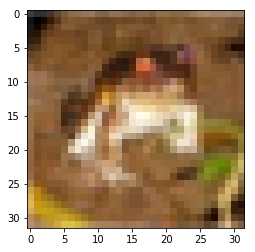

In [8]:
plt.figure()
plt.imshow(x_train[0])

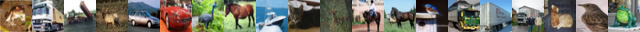

In [9]:
def showX(X):
    int_X_reshape = X.astype(np.uint8).reshape(-1,32,32, 3).swapaxes(0,1).reshape(32,-1,3)
    display(Image.fromarray(int_X_reshape, mode='RGB'))

showX(x_train[:20])

In [10]:
y_train[:20].T

array([[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]],
      dtype=uint8)

## Test central crop

(5000, 32, 32, 3)
(5000, 28, 28, 3)


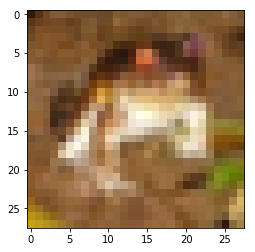

In [11]:
print(x_train.shape)
test = tf.image.central_crop(tf.convert_to_tensor(x_train), central_fraction=0.875)
print(test.shape)
plt.figure()
plt.imshow(test[0])

## Build Tensorflow Dataset

In [0]:
def preprocess(x, y, crop=False):
  x = tf.cast(x, tf.float32) / 127.5 - 1 
  
  if crop:
    x = tf.image.central_crop(x, central_fraction=0.875) # 32 -> 28
  x = tf.expand_dims(x, axis=-1)

  y = tf.one_hot(tf.squeeze(y,axis=-1), 10)
  
  return x, y

preprocessed_data = preprocess(x_train, y_train, crop=True)

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 32

ds_train = tf.data.Dataset.from_tensor_slices(preprocessed_data)
ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
a_batch = next(iter(ds_train))
a_batch[0].shape, a_batch[1].shape

(TensorShape([32, 28, 28, 3, 1]), TensorShape([32, 10]))

In [0]:
# Define generator
LATENT_DIM = 100
class Generator(Model):
  def __init__(self):
    super().__init__()
    self.fc1 = layers.Dense(3*3*3*256, use_bias=False, input_shape=(LATENT_DIM + 10,))
    self.bn = [layers.BatchNormalization() for _ in range(6)]

    self.convtr_0 = layers.Conv3DTranspose(192, (3,3,1), strides=(2,2,1), padding="valid", use_bias=False)
    self.convtr_1 = layers.Conv3DTranspose(128, (4,4,1), strides=(2,2,1), padding="valid", use_bias=False)
    self.convtr_2 = layers.Conv3DTranspose(64, (4,4,1), strides=(1,1,1), padding="valid", use_bias=False)
    self.convtr_3 = layers.Conv3DTranspose(32, (4,4,1), strides=(1,1,1), padding="valid", use_bias=False)
    self.convtr_4 = layers.Conv3DTranspose(16, (4,4,1), strides=(1,1,1), padding="valid", use_bias=False)
    self.convtr_5 = layers.Conv3DTranspose(1, (4,4,1), strides=(1,1,1), padding="valid", activation="tanh")
    
  @tf.function
  def call(self, inputs, is_training=False):
    x = layers.concatenate([inputs[0], inputs[1]]) # bs, latent_dim+10
    x = self.fc1(x)
    x = self.bn[0](x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = tf.reshape(x, shape=[-1,3,3,3,256])

    x = self.convtr_0(x) # bs, 7, 7, 3, 192
    x = self.bn[1](x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.convtr_1(x) # bs, 16, 16, 3, 128
    x = self.bn[2](x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.convtr_2(x) # bs, 19, 19, 3, 64
    x = self.bn[3](x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.convtr_3(x) # bs, 22, 22, 3, 32
    x = self.bn[4](x, training=is_training)
    x = tf.nn.leaky_relu(x)

    x = self.convtr_4(x) # bs, 25, 25, 3, 16
    x = self.bn[5](x, training=is_training)
    x = tf.nn.leaky_relu(x)
    
    x = self.convtr_5(x) # bs, 28, 28, 3, 1(RGB)
    return x

In [0]:
# DEFINE Discriminator
class Discriminator(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv3D(64, (5,5,3), strides=(2,2,1), padding="SAME")
    self.drop1 = layers.Dropout(0.3)
    self.conv2 = layers.Conv3D(128, (5,5,3), strides=(2,2,1), padding="SAME")
    self.drop2 = layers.Dropout(0.3)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(50)
    self.bn = layers.BatchNormalization()
    self.fc2 = layers.Dense(1)
  @tf.function 
  def call(self, inputs, is_training=False):
    x = self.conv1(inputs[0]) # bs, 14, 14, 3, 64
    x = tf.nn.leaky_relu(x)
    x = self.drop1(x, training=is_training)
    x = self.conv2(x) # bs, 7, 7, 3, 128
    x = tf.nn.leaky_relu(x)
    x = self.drop2(x, training=is_training)
    x = self.flatten(x)
    x = layers.concatenate([x, inputs[1]]) # bs, 7x7x3x128+10
    x = self.fc1(x) # bs, 50
    x = self.bn(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.fc2(x) # bs, 1
    
    return x

In [16]:
generator = Generator()
discriminator = Discriminator()
generator.build(input_shape=[(None,LATENT_DIM),(None,10)])
discriminator.build(input_shape=[(None,28,28,3,1),(None,10)])

In [0]:
# Define both loss function
def generator_loss(generated_output):
  return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output, from_logits=True))

In [0]:
def discriminator_loss(real_output, generated_output):
  
  real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True))
  generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output, from_logits=True))

  total_loss = real_loss + generated_loss

  return total_loss

In [0]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [0]:
EPOCHS = 100
num_examples_to_generate = 20

# reuse this vector
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 LATENT_DIM])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [0]:
@tf.function
def train_step(images, labels):
  noise = tf.random.normal([labels.shape[0], LATENT_DIM]) # handle remainder
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([noise, labels], is_training=True)

    real_output = discriminator([images, labels], is_training=True)
    generated_output = discriminator([generated_images, labels], is_training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def plot_numBar(images):
  images = np.uint8(images*127.5+128).clip(0, 255)[..., 0]
  concat_image = np.transpose(images, [1,0,2,3]).reshape((28,-1,3))
  display(Image.fromarray(concat_image))

In [23]:
for epoch in range(EPOCHS):
  start_time = time.time()
  for images, labels in ds_train:
    train_step(images, labels)
  
  fake = generator([random_vector_for_generation, condition_vector_generation], is_training=False)
  print(epoch, time.time()-start_time)
  plot_numBar(fake)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 30.23007345199585


1 17.443633794784546


2 17.488471508026123


3 17.526267051696777


4 17.652709245681763


5 17.681018352508545


6 17.678568840026855


7 17.70848512649536


8 17.620631456375122


9 17.635350704193115


10 17.64287257194519


11 17.710514068603516


12 17.649726152420044


13 17.60858964920044


14 17.64818572998047


15 17.61516046524048


16 17.614618062973022


17 17.62887144088745


18 17.657423734664917


19 17.704912900924683


20 17.662730932235718


21 17.71422576904297


22 17.65432834625244


23 17.67780900001526


24 17.665355443954468


25 17.643079042434692


26 17.62555480003357


27 17.594264030456543


28 17.666210889816284


29 17.690210342407227


30 17.702889680862427


31 17.682822704315186


32 17.708333730697632


33 17.702513217926025


34 17.681930780410767


35 17.652204751968384


36 17.697413682937622


37 17.692057132720947


38 17.67850971221924


39 17.671729564666748


40 17.685039043426514


41 17.679435968399048


42 17.687182903289795


43 17.66367483139038


44 17.690375089645386


45 17.675742149353027


46 17.67803978919983


47 17.68260383605957


48 17.69802975654602


49 17.689061164855957


50 17.67119574546814


51 17.66963505744934


52 17.706204414367676


53 17.701038122177124


54 17.63343119621277


55 17.594095468521118


56 17.701007843017578


57 17.68251609802246


58 17.610575199127197


59 17.694414377212524


60 17.662227153778076


61 17.685404777526855


62 17.631866931915283


63 17.606210470199585


64 17.656849145889282


65 17.67733144760132


66 17.66596245765686


67 17.66511631011963


68 17.65754985809326


69 17.697598218917847


70 17.672261714935303


71 17.653947591781616


72 17.603272438049316


73 17.602375030517578


74 17.666484355926514


75 17.668609142303467


76 17.589284896850586


77 17.647641897201538


78 17.601858615875244


79 17.619446516036987


80 17.636897087097168


81 17.660001277923584


82 17.661763668060303


83 17.630468368530273


84 17.68822455406189


85 17.654396533966064


86 17.674326181411743


87 17.66143488883972


88 17.629896640777588


89 17.646424770355225


90 17.624566078186035


91 17.64630675315857


92 17.695971488952637


93 17.658394813537598


94 17.66774606704712


95 17.665710926055908


96 17.681134462356567


97 17.68070340156555


98 17.65850520133972


99 17.633008241653442


In [0]:
MODEL_PATH = 'drive/My Drive/Colab Notebooks/mount/models/cifar10_GAN_deeper/alldata'
generator.save_weights(MODEL_PATH, save_format='tf')

In [25]:
# load & use model
new_model = Generator()
new_model.build(input_shape=[(None,LATENT_DIM),(None,10)])
noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
image, label = next(iter(ds_train))

# before load weights
bad_images = new_model([noise, label], is_training=True)
plot_numBar(bad_images)

In [26]:
new_model.load_weights(MODEL_PATH)

my_label = list([3,3,2,2,8,8,9,9,0,0])
noise = tf.random.normal([len(my_label), LATENT_DIM])
my_label = tf.one_hot(my_label, 10)

better = new_model([noise, my_label])

plot_numBar(better)